# Group 96

# Machine Learning - ARX Model

$$y(k) + a_1y(k-1) + \dots + a_ny(k-n) = b_0u(k-d)+ \dots + b_mu(k-d-m) + e(k)$$

Where 

$\bullet$ $k$ : discrete time $[0,N-1]$

$\bullet$ $y$ : output sequence

$\bullet$  $u \in R^{N}$ : input sequence 

$\bullet $   $e$ : noise sequence

$\bullet $   $n\geq 0, m\geq 0, d\geq 0$ : model order parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split   

## Split function

In [2]:
def split(X_set,Y_set):
    split_number = (X_set.shape[0]*20)//100

    #From beginning to the split number
    X_train_splitted = X_set[split_number:]

    #From the split number to the end
    X_val = X_set[:split_number]

    #From beginning to the split number
    Y_train_splitted = Y_set[split_number:]
    
    Y_val = Y_set[:split_number]
    return X_train_splitted,X_val,Y_train_splitted,Y_val

## Data importation

In [3]:
# Data importation
u_test = np.load('u_test.npy')
u_train = np.load('u_train.npy')
output_train = np.load('output_train.npy')

# Splitting the data
u_train, u_val, output_train, output_val = split(u_train,output_train)

print('Size of the training data:', u_train.shape)
print('Size of the validation data:', u_val.shape)
print('Size of the output data:', output_train.shape)
print('Size of the output validation data:', output_val.shape)

Size of the training data: (1632,)
Size of the validation data: (408,)
Size of the output data: (1632,)
Size of the output validation data: (408,)


The problem can be formulated as a linear regression :

$$y(k) = \phi(k)^{T}\theta + e(k)$$

where 

$$\phi(k) = [y(k-1),\dots,y(k-n),u(k-d),\dots,u(k-d-m)]^{T}$$

and 

$$ \theta = [-a_1,\dots,-a_n,b_0,\dots,b_m]$$

The systeme is initially at rest $(y(k) = 0, \forall k < 0)$

**For given $n$, $m$ and $d$ and a sequence of input-output the model is rewritten in matrix form** :

$$Y = X\theta$$

$Y = [y(p),\dots,y(N-1)]^{T}$, $X = [\phi(p),\dots,\phi(N-1)]^{T}$, $p = max(n,d+m)$

We assume that $n<10$, $m<10$, $d<10$.

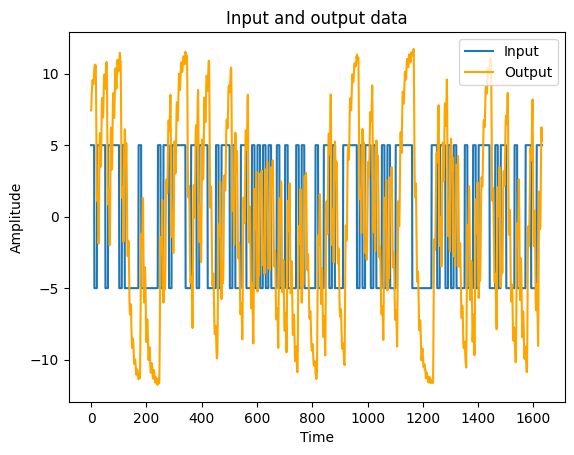

In [4]:
plt.plot(range(0,u_train.shape[0]), u_train,label='Input')
plt.plot(range(0,u_train.shape[0]), output_train, label='Output',color='orange')
plt.legend()
plt.title('Input and output data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

## Functions definitions

### Function $\phi$ 

In [5]:
# phi function
def phi(k,n,d,m,u_input,y_output):
    """u_input: input data
       y_output: output data
       p: time
       phi(p) = [y(p-1),y(p-2),...,y(p-n),u(p-d),u(p-d-1),...,u(p-d-m)]
    """

    # first part of the vector for y(k-1) to y(k-n)
    if n==0:
        first_part = np.zeros(1)
        first_part[0] = y_output[0]

    else:
        first_part = np.zeros(n)

    for i in range(1,n+1):
        if k-i < 0:
            first_part[i-1] = 0
        else :
            first_part[i-1] = y_output[k-i]

    # second part of the vector for u(k-d) to u(k-d-m)

    if m==0:   
        second_part = np.zeros(1)

    else :
        second_part = np.zeros(m+1)
    
    for i in range(d,d+m+1):
        if k-i < 0:
            second_part[i-d] = 0
        second_part[i-d] = u_input[k-i]
        
    # concatenation of the two parts
    phi = np.concatenate((first_part,second_part))
    #print('Size of phi:', phi.shape, "the size of n+m+1 is :", n+m+1)

    return phi

print(phi(1,1,0,0,u_train,output_train))
print(phi(1,0,1,0,u_train,output_train))
print(phi(1,0,0,1,u_train,output_train))
print(phi(0,0,0,0,u_train,output_train))

[7.43898318 5.        ]
[7.43898318 5.        ]
[7.43898318 5.         5.        ]
[7.43898318 5.        ]


### Creation of the X matrix 

In [6]:
def X_creation(p,n,d,m,u_input,y_output) :

    X = np.zeros([u_input.shape[0]-1-p,n+m+1])
    if n==0:
        
        X = np.zeros([u_input.shape[0]-1-p,m+2])

    if p == 1:

        if (n==0) | (d==1):

            X = np.zeros([u_input.shape[0]-1-p,2])

        if m==1 :

            X = np.zeros([u_input.shape[0]-1-p,3])

    if p == 0 :
        X = np.zeros([u_input.shape[0]-1-p,2])
    
   

    for k in range(p,u_input.shape[0]-1) :
        phi_k = phi(k,n,d,m,u_input,y_output)
        X[k-p,:] = phi_k
        
    return X

print(X_creation(1,1,0,0,u_train,output_train))
print(X_creation(1,0,1,0,u_train,output_train))
print(X_creation(1,0,0,1,u_train,output_train))
print(X_creation(0,0,0,0,u_train,output_train))

[[7.43898318 5.        ]
 [7.57183995 5.        ]
 [8.40925935 5.        ]
 ...
 [2.83921742 5.        ]
 [5.06508197 5.        ]
 [6.25651479 5.        ]]
[[7.43898318 5.        ]
 [7.43898318 5.        ]
 [7.43898318 5.        ]
 ...
 [7.43898318 5.        ]
 [7.43898318 5.        ]
 [7.43898318 5.        ]]
[[7.43898318 5.         5.        ]
 [7.43898318 5.         5.        ]
 [7.43898318 5.         5.        ]
 ...
 [7.43898318 5.         5.        ]
 [7.43898318 5.         5.        ]
 [7.43898318 5.         5.        ]]
[[7.43898318 5.        ]
 [7.43898318 5.        ]
 [7.43898318 5.        ]
 ...
 [7.43898318 5.        ]
 [7.43898318 5.        ]
 [7.43898318 5.        ]]


### Function $y(k)$

In [7]:
def y(k,n,d,m,u_input,y_output,theta) :
    """
    y(k) = phi(k)*theta + noise
    """
    return np.dot(phi(k,n,d,m,u_input,y_output),theta)

### Parameter P 

In [8]:
def p_calculation(n,d,m):
    values = np.array((n,d+m))
    return np.max(values)

## Creation of the DataFrame

We are going to create a DataFrame where we can store the combination of paremeters used to create each "feature" matrix and the resulting SSE of the respective model    

In [9]:
# Crecreation of parameters 
n_seq = np.arange(0,10)
d_seq = np.arange(0,10)
m_seq = np.arange(0,10)


# Creation of a suppor array
m_zeros = np.zeros((np.size(n_seq)*np.size(d_seq)*np.size(m_seq),5))

# Columns names
c_names = ['n','d','m','p','SSE']

# Creation of the DataFrame
df_results = pd.DataFrame(data = m_zeros, columns = c_names) 

df_results.head()

,n,d,m,p,SSE
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


## Linear Regression

### The best parameters

In [10]:
lr_list = [] 
lr = LinearRegression()

cont = 0

for n in n_seq:
    for d in d_seq:
        for m in m_seq:
            p = p_calculation(n,d,m)

            # Training
            X_train = X_creation(p,n,d,m,u_train,output_train)
            Y_train = output_train[p:output_train.shape[0]-1]
            lr_list.append(lr.fit(X_train,Y_train))

            # Validation
            X_val = X_creation(p,n,d,m,u_val,output_val)
            Y_val = output_val[p:output_val.shape[0]-1]

            # Prediction                
            SSE = mean_squared_error(Y_val,lr.predict(X_val))
            
            df_results.iloc[cont] = [n,d,m,p,SSE]
            cont +=1

df_results.head()

,n,d,m,p,SSE
0,0.0,0.0,0.0,0.0,47.467125
1,0.0,0.0,1.0,1.0,45.033558
2,0.0,0.0,2.0,2.0,42.397169
3,0.0,0.0,3.0,3.0,39.558129
4,0.0,0.0,4.0,4.0,36.221766


In [11]:
min_SSE = df_results['SSE'].min()
min_row = np.where(df_results['SSE']==min_SSE)
df_results.iloc[min_row[0][0]]
n = int(df_results.iloc[min_row[0][0]]['n'])
d = int(df_results.iloc[min_row[0][0]]['d'])
m = int(df_results.iloc[min_row[0][0]]['m'])
p = int(df_results.iloc[min_row[0][0]]['p'])
print('The optimal values are: n =',n,'d =',d,'m =',m,'p =',p,'and the minimum SSE is:',min_SSE)
print(X_val)

The optimal values are: n = 9 d = 6 m = 9 p = 15 and the minimum SSE is: 0.014395957817888962
[[7.87261599 7.14976495 6.53287049 ... 5.         5.         5.        ]
 [8.20902385 7.87261599 7.14976495 ... 5.         5.         5.        ]
 [7.85525466 8.20902385 7.87261599 ... 5.         5.         5.        ]
 ...
 [6.2041984  5.14557586 4.36343772 ... 5.         5.         5.        ]
 [7.33847051 6.2041984  5.14557586 ... 5.         5.         5.        ]
 [7.82681625 7.33847051 6.2041984  ... 5.         5.         5.        ]]


### Theta Estimation

In [12]:
best_model = lr_list[min_row[0][0]]
theta = best_model.coef_
print(theta.shape)

(19,)


### Predicted VS Real

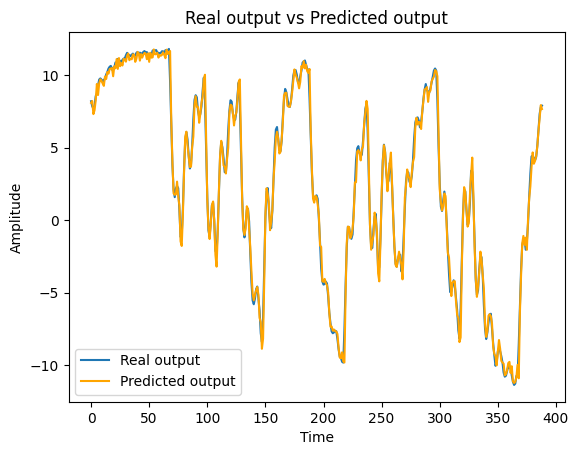

SSE: 0.24135469898525477
R2: 0.9945350532902344


In [13]:
Y_pred = best_model.predict(X_val)
plt.plot(range(0,Y_val.shape[0]),Y_val,label='Real output')
plt.plot(range(0,Y_pred.shape[0]),Y_pred,label='Predicted output',color='orange')
plt.legend()
plt.title('Real output vs Predicted output')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# SSE 
SSE = mean_squared_error(Y_val,Y_pred)
print('SSE:',SSE)

# R2
R2 = r2_score(Y_val,Y_pred)
print('R2:',R2)

The model is very accurate.

### Iterative vs Predicted

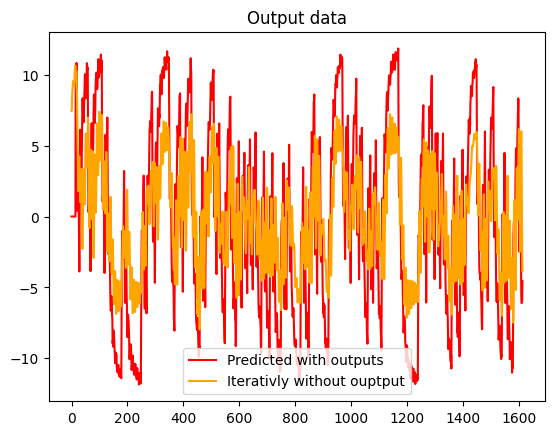

SSE: 39.72156690196482


In [14]:
# Computing y(k) for the test data
Y_pred_iter = np.zeros(Y_train.shape[0])
Y_pred_iter[:p] = output_train[:p]
Y_pred_iter_output = np.zeros(Y_train.shape[0])

for i in range(p,Y_train.shape[0]):
    Y_pred_iter[i] = np.dot(phi(i,n,d,m,u_train,Y_pred_iter),theta)
    Y_pred_iter_output[i] = y(i,n,d,m,u_train,output_train,theta)

#plotting the output data
plt.plot(range(0,Y_train.shape[0]),Y_pred_iter_output,label='Predicted with outputs',color='red',linestyle='-')
plt.plot(range(0,Y_pred_iter.shape[0]), Y_pred_iter,label='Iterativly without ouptput',color='orange')
plt.title('Output data')
plt.legend()
plt.show()

# SSE
SSE_iter = mean_squared_error(Y_train,Y_pred_iter)
print('SSE:',SSE_iter)

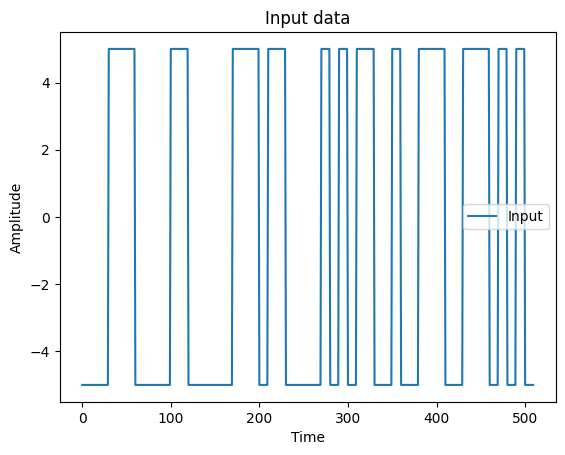

In [15]:
# input data 
plt.plot(range(0,u_test.shape[0]), u_test,label='Input')    
plt.legend()
plt.title('Input data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


### Predictions

(510,)
(100,)
(400,)


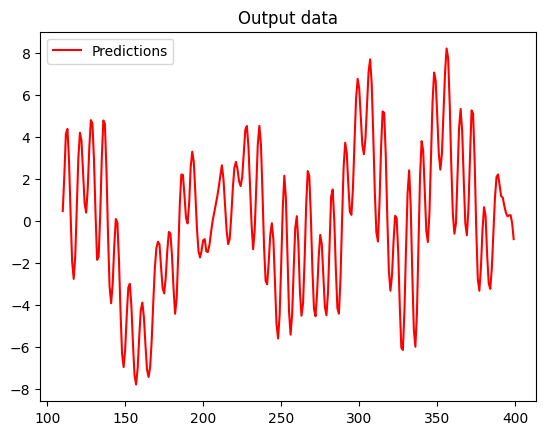

In [24]:
# Computing y(k) for the test data
Y_test = np.zeros(u_test.shape[0])
print(Y_test.shape)
print(output_train[len(output_train)-100:].shape)

# The first 100 values are taken from the training data
Y_test[:100] = output_train[len(output_train)-100:]

for k in range(100,Y_test.shape[0]):
    Y_test[k] = np.dot(phi(k,n,d,m,u_test,Y_test),theta)
    
# Only the 400 last values are taken
Y_test = Y_test[len(Y_test)-400:]
print(Y_test.shape)

#plotting the output data
plt.plot(range(110,Y_test.shape[0]),Y_test[110:],label='Predictions',color='red',linestyle='-')
plt.title('Output data')
plt.legend()
plt.show()

In [17]:
# Saving the output data
np.save('output_test.npy',Y_test)